### Read transformed data

In [46]:
import pandas as pd

df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")

df.head()

C:\Users\Rusty\AppData\Local\Temp\ipykernel_17924\3673202588.py:3: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,tourney_round,...,median_diff_rolling_mean_10,total_diff_rolling_mean_10,mean_tb_numb_rolling_mean_10,median_tb_numb_rolling_mean_10,total_tb_numb_rolling_mean_10,mean_tb_diff_rolling_mean_10,median_tb_diff_rolling_mean_10,total_tb_diff_rolling_mean_10,elo_next_match,player_hand_missing
0,1975-237,Sao Paulo WCT,Carpet,32.0,A,1975-03-10,2,6-1 6-1,3,R32,...,3.200000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
1,1975-2023,Fairfield,Carpet,32.0,A,1975-02-24,13,6-0 6-0,3,R32,...,4.700000,8.500000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0
2,1975-436,Charlotte,Clay,32.0,A,1975-04-21,7,6-4 3-6 6-4,3,R32,...,3.416667,5.857143,0.0,0.0,0.0,0.0,0.0,0.0,1571.881887,0
3,1974-2030,Merion,Grass,64.0,A,1974-08-25,247,6-2 6-2,3,R64,...,2.428571,5.428571,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
4,1977-345,Monterrey WCT,Carpet,16.0,A,1977-02-28,4,6-0 6-1,3,R16,...,3.611111,7.200000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177422 entries, 0 to 1177421
Columns: 132 entries, tourney_id to player_hand_missing
dtypes: float64(96), int64(16), object(20)
memory usage: 1.2+ GB


In [48]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'tourney_round',
       ...
       'median_diff_rolling_mean_10', 'total_diff_rolling_mean_10',
       'mean_tb_numb_rolling_mean_10', 'median_tb_numb_rolling_mean_10',
       'total_tb_numb_rolling_mean_10', 'mean_tb_diff_rolling_mean_10',
       'median_tb_diff_rolling_mean_10', 'total_tb_diff_rolling_mean_10',
       'elo_next_match', 'player_hand_missing'],
      dtype='object', length=132)

#### Add Average Win Rate

In [49]:
df_copy = df.copy()

player_agg = (
    df.groupby('player_id')
      .agg(
          player_name=('player_name', 'first'),
          total_wins=('match_outcome', 'sum'),
          matches_played=('match_outcome', 'count')
      )
      .reset_index()
)

# Calculate average win rate
player_agg['average_win_rate'] = round(player_agg['total_wins'] / player_agg['matches_played'], 2)

# Merge average_win_rate back into the full dataframe copy
df_copy = df_copy.merge(player_agg[['player_id', 'average_win_rate']], on='player_id', how='left')

# Aggregated table for summaries
player_stats = player_agg[['player_id', 'player_name', 'total_wins', 'matches_played', 'average_win_rate']]

# Display the first few rows of the player_stats dataframe sorted by matches played
player_stats.sort_values(by='matches_played', ascending=False).head()

,player_id,player_name,total_wins,matches_played,average_win_rate
1656,103819,Roger Federer,1237,1492,0.83
2742,104925,Novak Djokovic,1183,1420,0.83
2566,104745,Rafael Nadal,1160,1410,0.82
1728,103893,Paolo Lorenzi,704,1309,0.54
1804,103970,David Ferrer,858,1298,0.66


#### Wins against a top 10 opponent

In [ ]:
# Build a time-aware binary flag 'has_ever_beaten_top_10'
# We find winner matches where the opponent's rank <= 10, then for each player
# compute a cumulative max ordered by match date so the flag is 1 from that match onward.

date_col = 'tourney_date'
df_copy[date_col] = pd.to_datetime(df_copy[date_col], errors='coerce')

# Prepare per-player match list (one row per player per match) to compute the cumulative flag
player_matches = df_copy[['player_id', 'player_tourney_match_id', date_col]].copy()
player_matches['tourney_match_id'] = player_matches['player_tourney_match_id'].str.split(':').str[1:].str.join(':')

# Identify winner rows and their opponent's rank by matching winners to losers within the same tourney match id
winners = df_copy[df_copy['match_outcome'] == 1][['player_tourney_match_id', 'player_id']].copy()
losers = df_copy[df_copy['match_outcome'] == 0][['player_tourney_match_id', 'player_rank']].copy()
winners['tourney_match_id'] = winners['player_tourney_match_id'].str.split(':').str[1:].str.join(':')
losers['tourney_match_id'] = losers['player_tourney_match_id'].str.split(':').str[1:].str.join(':')
losers = losers.rename(columns={'player_rank': 'opponent_rank'})

winner_vs_loser = pd.merge(
    winners[['player_id', 'tourney_match_id']],
    losers[['tourney_match_id', 'opponent_rank']],
    on='tourney_match_id',
    how='inner'
)

# Mark events where the winner beat a top-10 opponent
winner_vs_loser['beat_top10_event'] = (winner_vs_loser['opponent_rank'] <= 10).astype(int)

# Merge the event flag into the per-player-per-match timeline (only winners will have non-zero events)
player_matches = player_matches.merge(
    winner_vs_loser[['player_id', 'tourney_match_id', 'beat_top10_event']],
    left_on=['player_id', 'tourney_match_id'],
    right_on=['player_id', 'tourney_match_id'],
    how='left'
)
player_matches['beat_top10_event'] = player_matches['beat_top10_event'].fillna(0).astype(int)

# Sort within each player by date (or by original order if date missing) and compute cumulative max
if date_col:
    player_matches = player_matches.sort_values(['player_id', date_col, 'tourney_match_id'])
else:
    player_matches = player_matches.sort_values(['player_id', 'tourney_match_id'])

player_matches['has_ever_beaten_top_10'] = player_matches.groupby('player_id')['beat_top10_event'].cummax().astype(int)

# Merge the result back into df_copy on player_id + player_tourney_match_id so every row (win or loss) gets the correct flag
df_copy = df_copy.merge(
    player_matches[['player_id', 'player_tourney_match_id', 'has_ever_beaten_top_10']],
    on=['player_id', 'player_tourney_match_id'],
    how='left'
)
df_copy['has_ever_beaten_top_10'] = df_copy['has_ever_beaten_top_10'].fillna(0).astype(int)

In [ ]:
# Show all matches for a single player (Novak Djokovic) to see the flag flip to 1
player_name_example = 'Novak Djokovic'
player_rows = df_copy[df_copy['player_name'].str.contains(player_name_example, case=False, na=False)].copy()
player_rows = player_rows.sort_values('tourney_date')
cols = ['tourney_date', 'player_tourney_match_id', 'player_name', 'match_outcome', 'player_rank', 'has_ever_beaten_top_10']
# display all matches
display(player_rows[cols].reset_index(drop=True))

# Show the first match where the flag becomes 1
first_flip = player_rows[player_rows['has_ever_beaten_top_10'] == 1].head(1)
if not first_flip.empty:
    print('\nFirst match where has_ever_beaten_top_10==1:')
    display(first_flip[cols])
else:
    print('\nNo top-10 beating event found for this player in the dataset.')

,tourney_date,player_tourney_match_id,player_name,match_outcome,player_rank,has_ever_beaten_top_10
0,2003-07-14,104925:2003-M-FU-SCG-04A-2003:12,Novak Djokovic,1,768.0,0
1,2003-07-14,104925:2003-M-FU-SCG-04A-2003:22,Novak Djokovic,1,768.0,0
2,2003-07-14,104925:2003-M-FU-SCG-04A-2003:27,Novak Djokovic,1,768.0,0
3,2003-07-14,104925:2003-M-FU-SCG-04A-2003:30,Novak Djokovic,0,768.0,0
4,2003-07-21,104925:2003-M-FU-SCG-05A-2003:2,Novak Djokovic,0,774.0,0
...,...,...,...,...,...,...
1415,2024-10-02,104925:2024-5014:357,Novak Djokovic,1,4.0,1
1416,2024-10-02,104925:2024-5014:367,Novak Djokovic,1,4.0,1
1417,2024-10-02,104925:2024-5014:315,Novak Djokovic,1,4.0,1
1418,2024-10-02,104925:2024-5014:343,Novak Djokovic,1,4.0,1



First match where has_ever_beaten_top_10==1:


,tourney_date,player_tourney_match_id,player_name,match_outcome,player_rank,has_ever_beaten_top_10
488403,2005-10-31,104925:2005-352:35,Novak Djokovic,0,85.0,1


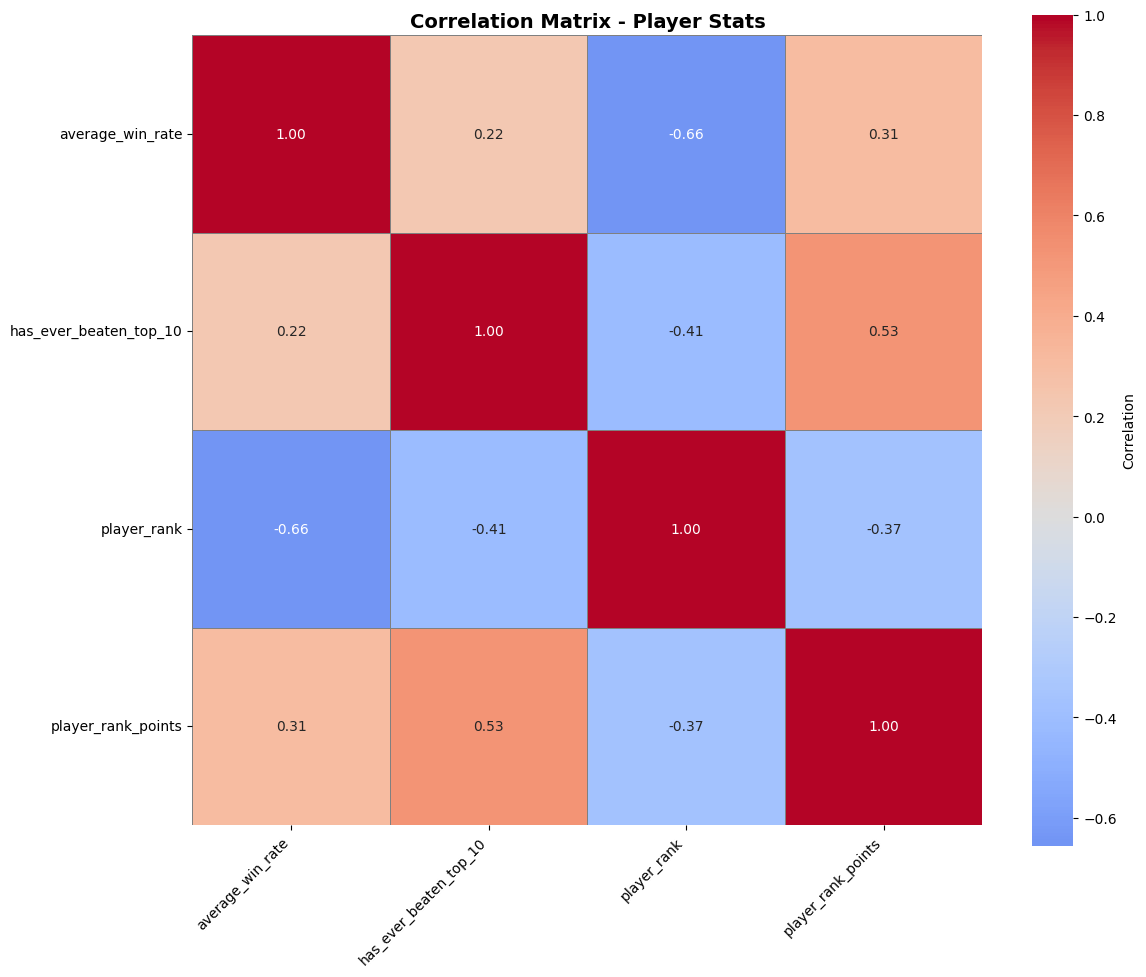

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix of numeric columns in player_stats
cols = ['average_win_rate', 'has_ever_beaten_top_10', 'player_rank', 'player_rank_points']
corr_matrix = df_copy[cols].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.2f', cbar_kws={'label': 'Correlation'}, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix - Player Stats', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()